## LangGraph Open Deep Research - Supervisor-Researcher Architecture

In this notebook, we'll explore the **supervisor-researcher delegation architecture** for conducting deep research with LangGraph.

You can visit this repository to see the original application: [Open Deep Research](https://github.com/langchain-ai/open_deep_research)

Let's jump in!

## What We're Building

This implementation uses a **hierarchical delegation pattern** where:

1. **User Clarification** - Optionally asks clarifying questions to understand the research scope
2. **Research Brief Generation** - Transforms user messages into a structured research brief
3. **Supervisor** - A lead researcher that analyzes the brief and delegates research tasks
4. **Parallel Researchers** - Multiple sub-agents that conduct focused research simultaneously
5. **Research Compression** - Each researcher synthesizes their findings
6. **Final Report** - All findings are combined into a comprehensive report

![Architecture Diagram](https://private-user-images.githubusercontent.com/181020547/465824799-12a2371b-8be2-4219-9b48-90503eb43c69.png?jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmF3LmdpdGh1YnVzZXJjb250ZW50LmNvbSIsImtleSI6ImtleTUiLCJleHAiOjE3NjAwNDgyMzcsIm5iZiI6MTc2MDA0NzkzNywicGF0aCI6Ii8xODEwMjA1NDcvNDY1ODI0Nzk5LTEyYTIzNzFiLThiZTItNDIxOS05YjQ4LTkwNTAzZWI0M2M2OS5wbmc_WC1BbXotQWxnb3JpdGhtPUFXUzQtSE1BQy1TSEEyNTYmWC1BbXotQ3JlZGVudGlhbD1BS0lBVkNPRFlMU0E1M1BRSzRaQSUyRjIwMjUxMDA5JTJGdXMtZWFzdC0xJTJGczMlMkZhd3M0X3JlcXVlc3QmWC1BbXotRGF0ZT0yMDI1MTAwOVQyMjEyMTdaJlgtQW16LUV4cGlyZXM9MzAwJlgtQW16LVNpZ25hdHVyZT1iYTRmYTAzYjkzYjA2MGE4ZTZlYjQ4ODU1OWIwY2VlZWU0Mzk0YzdmMjQ1YTlhMDMyNmI3NWNlZTQxNDdlZGViJlgtQW16LVNpZ25lZEhlYWRlcnM9aG9zdCJ9.a8477QD1J4Lrmys7jB8gt_H5pdiKBsKsu3npEqZjEpo)

This differs from a section-based approach by allowing dynamic task decomposition based on the research question, rather than predefined sections.

## Dependencies

You'll need API keys for Anthropic (for the LLM) and Tavily (for web search). We'll configure the system to use Anthropic's Claude Sonnet 4 exclusively.

In [2]:
import os
import getpass

os.environ["ANTHROPIC_API_KEY"] = getpass.getpass("Enter your Anthropic API key: ")
os.environ["TAVILY_API_KEY"] = getpass.getpass("Enter your Tavily API key: ")
os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API key: ")

## Task 1: State Definitions

The state structure is hierarchical with three levels:

### Agent State (Top Level)
Contains the overall conversation messages, research brief, accumulated notes, and final report.

### Supervisor State (Middle Level)
Manages the research supervisor's messages, research iterations, and coordinating parallel researchers.

### Researcher State (Bottom Level)
Each individual researcher has their own message history, tool call iterations, and research findings.

We also have structured outputs for tool calling:
- **ConductResearch** - Tool for supervisor to delegate research to a sub-agent
- **ResearchComplete** - Tool to signal research phase is done
- **ClarifyWithUser** - Structured output for asking clarifying questions
- **ResearchQuestion** - Structured output for the research brief

Let's import these from our library: [`open_deep_library/state.py`](open_deep_library/state.py)

In [6]:
# Import state definitions from the library
from open_deep_library.state import (
    # Main workflow states
    AgentState,           
    AgentInputState,   
    
    # Supervisor states
    SupervisorState,    
    
    # Researcher states
    ResearcherState,     
    ResearcherOutputState, 
    
    # Structured outputs for tool calling
    ConductResearch,    
    ResearchComplete,    
    ClarifyWithUser,     
    ResearchQuestion,    
)

#### ❓ Question 1:

 Explain the interrelationships between the three states.  Why don't we just make a single huge state?

**AgentState:** <br>
Serves as the main orchestrator, containing the overall conversation flow and final outputs with fields for messages, supervisor_messages, research_brief, notes, raw_notes, and final_report. <br>
**SupervisorState:**<br>
Manages strategic decision-making and delegation, maintaining supervisor_messages, research_brief, notes, research_iterations, and raw_notes to handle research coordination and parallel researcher management.
**Individual ResearcherState instances:** <br>
Provide isolated environments for focused research execution, each containing researcher_messages, tool_call_iterations, research_topic, compressed_research, and raw_notes to manage specific research tasks without interference from other parallel researchers. This hierarchical design allows multiple researchers to work simultaneously while maintaining clear data flow and preventing state conflicts between different phases of the research workflow.

This hierarchical design allows for clean separation of concerns, parallel execution, and scalable research workflows while maintaining clear data flow between the different phases of the research process.

## Task 2: Utility Functions and Tools

The system uses several key utilities:

### Search Tools
- **tavily_search** - Async web search with automatic summarization to stay within token limits
- Supports Anthropic native web search and Tavily API

### Reflection Tools
- **think_tool** - Allows researchers to reflect on their progress and plan next steps (ReAct pattern)

### Helper Utilities
- **get_all_tools** - Assembles the complete toolkit (search + MCP + reflection)
- **get_today_str** - Provides current date context for research
- Token limit handling utilities for graceful degradation

These are defined in [`open_deep_library/utils.py`](open_deep_library/utils.py)

In [7]:
from open_deep_library.utils import (
    tavily_search,
    
    think_tool,
    
    get_all_tools,
    
    get_today_str,
    
    get_api_key_for_model,          
    is_token_limit_exceeded,        
    get_model_token_limit,         
    remove_up_to_last_ai_message,    
    anthropic_websearch_called,      
    openai_websearch_called,        
    get_notes_from_tool_calls,     
)

### ❓ Question 2:  

What are the advantages and disadvantages of importing these components instead of including them in the notebook?

Importing components offers significant advantages in code organization, reusability, and maintainability by separating concerns into focused modules that can be tested, versioned, and shared across multiple notebooks. This approach enables better IDE support, faster execution through caching, and professional development practices like unit testing and proper documentation. However, it creates abstraction overhead and debugging complexity since implementation details are hidden from the notebook, making it harder for users to understand and modify the system. The educational value is reduced as core logic becomes less transparent, and there's added deployment complexity when sharing notebooks. The current implementation uses a hybrid approach that balances these trade-offs by keeping core functionality in the library while providing comprehensive documentation and line references in the notebook, offering both modularity and transparency for learning and experimentation.

## Task 3: Configuration System

The configuration system controls:

### Research Behavior
- **allow_clarification** - Whether to ask clarifying questions before research
- **max_concurrent_research_units** - How many parallel researchers can run (default: 5)
- **max_researcher_iterations** - How many times supervisor can delegate research (default: 6)
- **max_react_tool_calls** - Tool call limit per researcher (default: 10)

### Model Configuration
- **research_model** - Model for research and supervision (we'll use Anthropic)
- **compression_model** - Model for synthesizing findings
- **final_report_model** - Model for writing the final report
- **summarization_model** - Model for summarizing web search results

### Search Configuration
- **search_api** - Which search API to use (ANTHROPIC, TAVILY, or NONE)
- **max_content_length** - Character limit before summarization

Defined in [`open_deep_library/configuration.py`](open_deep_library/configuration.py)

In [8]:
# Import configuration from the library
from open_deep_library.configuration import (
    Configuration,    # Lines 38-247: Main configuration class with all settings
    SearchAPI,        # Lines 11-17: Enum for search API options (ANTHROPIC, TAVILY, NONE)
)

## Task 4: Prompt Templates

The system uses carefully engineered prompts for each phase:

### Phase 1: Clarification
**clarify_with_user_instructions** - Analyzes if the research scope is clear or needs clarification

### Phase 2: Research Brief
**transform_messages_into_research_topic_prompt** - Converts user messages into a detailed research brief

### Phase 3: Supervisor
**lead_researcher_prompt** - System prompt for the supervisor that manages delegation strategy

### Phase 4: Researcher
**research_system_prompt** - System prompt for individual researchers conducting focused research

### Phase 5: Compression
**compress_research_system_prompt** - Prompt for synthesizing research findings without losing information

### Phase 6: Final Report
**final_report_generation_prompt** - Comprehensive prompt for writing the final report

All prompts are defined in [`open_deep_library/prompts.py`](open_deep_library/prompts.py)

In [9]:
# Import prompt templates from the library
from open_deep_library.prompts import (
    clarify_with_user_instructions,                    # Lines 3-41: Ask clarifying questions
    transform_messages_into_research_topic_prompt,     # Lines 44-77: Generate research brief
    lead_researcher_prompt,                            # Lines 79-136: Supervisor system prompt
    research_system_prompt,                            # Lines 138-183: Researcher system prompt
    compress_research_system_prompt,                   # Lines 186-222: Research compression prompt
    final_report_generation_prompt,                    # Lines 228-308: Final report generation
)

## Task 5: Node Functions - The Building Blocks

Now let's look at the node functions that make up our graph. We'll import them from the library and understand what each does.

### The Complete Research Workflow

The workflow consists of 8 key nodes organized into 3 subgraphs:

1. **Main Graph Nodes:**
   - `clarify_with_user` - Entry point that checks if clarification is needed
   - `write_research_brief` - Transforms user input into structured research brief
   - `final_report_generation` - Synthesizes all research into final report

2. **Supervisor Subgraph Nodes:**
   - `supervisor` - Lead researcher that plans and delegates
   - `supervisor_tools` - Executes supervisor's tool calls (delegation, reflection)

3. **Researcher Subgraph Nodes:**
   - `researcher` - Individual researcher conducting focused research
   - `researcher_tools` - Executes researcher's tool calls (search, reflection)
   - `compress_research` - Synthesizes researcher's findings

All nodes are defined in [`open_deep_library/deep_researcher.py`](open_deep_library/deep_researcher.py)

### Node 1: clarify_with_user

**Purpose:** Analyzes user messages and asks clarifying questions if the research scope is unclear.

**Key Steps:**
1. Check if clarification is enabled in configuration
2. Use structured output to analyze if clarification is needed
3. If needed, end with a clarifying question for the user
4. If not needed, proceed to research brief with verification message

**Implementation:** [`open_deep_library/deep_researcher.py` lines 60-115](open_deep_library/deep_researcher.py#L60-L115)

In [10]:
# Import the clarify_with_user node
from open_deep_library.deep_researcher import clarify_with_user

### Node 2: write_research_brief

**Purpose:** Transforms user messages into a structured research brief for the supervisor.

**Key Steps:**
1. Use structured output to generate detailed research brief from messages
2. Initialize supervisor with system prompt and research brief
3. Set up supervisor messages with proper context

**Why this matters:** A well-structured research brief helps the supervisor make better delegation decisions.

**Implementation:** [`open_deep_library/deep_researcher.py` lines 118-175](open_deep_library/deep_researcher.py#L118-L175)

In [11]:
# Import the write_research_brief node
from open_deep_library.deep_researcher import write_research_brief

### Node 3: supervisor

**Purpose:** Lead research supervisor that plans research strategy and delegates to sub-researchers.

**Key Steps:**
1. Configure model with three tools:
   - `ConductResearch` - Delegate research to a sub-agent
   - `ResearchComplete` - Signal that research is done
   - `think_tool` - Strategic reflection before decisions
2. Generate response based on current context
3. Increment research iteration count
4. Proceed to tool execution

**Decision Making:** The supervisor uses `think_tool` to reflect before delegating research, ensuring thoughtful decomposition of the research question.

**Implementation:** [`open_deep_library/deep_researcher.py` lines 178-223](open_deep_library/deep_researcher.py#L178-L223)

In [12]:
# Import the supervisor node (from supervisor subgraph)
from open_deep_library.deep_researcher import supervisor

### Node 4: supervisor_tools

**Purpose:** Executes the supervisor's tool calls, including strategic thinking and research delegation.

**Key Steps:**
1. Check exit conditions:
   - Exceeded maximum iterations
   - No tool calls made
   - `ResearchComplete` called
2. Process `think_tool` calls for strategic reflection
3. Execute `ConductResearch` calls in parallel:
   - Spawn researcher subgraphs for each delegation
   - Limit to `max_concurrent_research_units` (default: 5)
   - Gather all results asynchronously
4. Aggregate findings and return to supervisor

**Parallel Execution:** This is where the magic happens - multiple researchers work simultaneously on different aspects of the research question.

**Implementation:** [`open_deep_library/deep_researcher.py` lines 225-349](open_deep_library/deep_researcher.py#L225-L349)

In [13]:
# Import the supervisor_tools node
from open_deep_library.deep_researcher import supervisor_tools

### Node 5: researcher

**Purpose:** Individual researcher that conducts focused research on a specific topic.

**Key Steps:**
1. Load all available tools (search, MCP, reflection)
2. Configure model with tools and researcher system prompt
3. Generate response with tool calls
4. Increment tool call iteration count

**ReAct Pattern:** Researchers use `think_tool` to reflect after each search, deciding whether to continue or provide their answer.

**Available Tools:**
- Search tools (Tavily or Anthropic native search)
- `think_tool` for strategic reflection
- `ResearchComplete` to signal completion
- MCP tools (if configured)

**Implementation:** [`open_deep_library/deep_researcher.py` lines 365-424](open_deep_library/deep_researcher.py#L365-L424)

In [14]:
# Import the researcher node (from researcher subgraph)
from open_deep_library.deep_researcher import researcher

### Node 6: researcher_tools

**Purpose:** Executes the researcher's tool calls, including searches and strategic reflection.

**Key Steps:**
1. Check early exit conditions (no tool calls, native search used)
2. Execute all tool calls in parallel:
   - Search tools fetch and summarize web content
   - `think_tool` records strategic reflections
   - MCP tools execute external integrations
3. Check late exit conditions:
   - Exceeded `max_react_tool_calls` (default: 10)
   - `ResearchComplete` called
4. Continue research loop or proceed to compression

**Error Handling:** Safely handles tool execution errors and continues with available results.

**Implementation:** [`open_deep_library/deep_researcher.py` lines 435-509](open_deep_library/deep_researcher.py#L435-L509)

In [15]:
# Import the researcher_tools node
from open_deep_library.deep_researcher import researcher_tools

### Node 7: compress_research

**Purpose:** Compresses and synthesizes research findings into a concise, structured summary.

**Key Steps:**
1. Configure compression model
2. Add compression instruction to messages
3. Attempt compression with retry logic:
   - If token limit exceeded, remove older messages
   - Retry up to 3 times
4. Extract raw notes from tool and AI messages
5. Return compressed research and raw notes

**Why Compression?** Researchers may accumulate lots of tool outputs and reflections. Compression ensures:
- All important information is preserved
- Redundant information is deduplicated
- Content stays within token limits for the final report

**Token Limit Handling:** Gracefully handles token limit errors by progressively truncating messages.

**Implementation:** [`open_deep_library/deep_researcher.py` lines 511-585](open_deep_library/deep_researcher.py#L511-L585)

In [16]:
# Import the compress_research node
from open_deep_library.deep_researcher import compress_research

### Node 8: final_report_generation

**Purpose:** Generates the final comprehensive research report from all collected findings.

**Key Steps:**
1. Extract all notes from completed research
2. Configure final report model
3. Attempt report generation with retry logic:
   - If token limit exceeded, truncate findings by 10%
   - Retry up to 3 times
4. Return final report or error message

**Token Limit Strategy:**
- First retry: Use model's token limit × 4 as character limit
- Subsequent retries: Reduce by 10% each time
- Graceful degradation with helpful error messages

**Report Quality:** The prompt guides the model to create well-structured reports with:
- Proper headings and sections
- Inline citations
- Comprehensive coverage of all findings
- Sources section at the end

**Implementation:** [`open_deep_library/deep_researcher.py` lines 607-697](open_deep_library/deep_researcher.py#L607-L697)

In [17]:
# Import the final_report_generation node
from open_deep_library.deep_researcher import final_report_generation

## Task 6: Graph Construction - Putting It All Together

The system is organized into three interconnected graphs:

### 1. Researcher Subgraph (Bottom Level)
Handles individual focused research on a specific topic:
```
START → researcher → researcher_tools → compress_research → END
               ↑            ↓
               └────────────┘ (loops until max iterations or ResearchComplete)
```

### 2. Supervisor Subgraph (Middle Level)
Manages research delegation and coordination:
```
START → supervisor → supervisor_tools → END
            ↑              ↓
            └──────────────┘ (loops until max iterations or ResearchComplete)
            
supervisor_tools spawns multiple researcher_subgraphs in parallel
```

### 3. Main Deep Researcher Graph (Top Level)
Orchestrates the complete research workflow:
```
START → clarify_with_user → write_research_brief → research_supervisor → final_report_generation → END
                 ↓                                       (supervisor_subgraph)
               (may end early if clarification needed)
```

Let's import the compiled graphs from the library.

In [18]:
# Import the pre-compiled graphs from the library
from open_deep_library.deep_researcher import (
    # Bottom level: Individual researcher workflow
    researcher_subgraph,    # Lines 588-605: researcher → researcher_tools → compress_research
    
    # Middle level: Supervisor coordination
    supervisor_subgraph,    # Lines 351-363: supervisor → supervisor_tools (spawns researchers)
    
    # Top level: Complete research workflow
    deep_researcher,        # Lines 699-719: Main graph with all phases
)

## Why This Architecture?

### Advantages of Supervisor-Researcher Delegation

1. **Dynamic Task Decomposition**
   - Unlike section-based approaches with predefined structure, the supervisor can break down research based on the actual question
   - Adapts to different types of research (comparisons, lists, deep dives, etc.)

2. **Parallel Execution**
   - Multiple researchers work simultaneously on different aspects
   - Much faster than sequential section processing
   - Configurable parallelism (1-20 concurrent researchers)

3. **ReAct Pattern for Quality**
   - Researchers use `think_tool` to reflect after each search
   - Prevents excessive searching and improves search quality
   - Natural stopping conditions based on information sufficiency

4. **Flexible Tool Integration**
   - Easy to add MCP tools for specialized research
   - Supports multiple search APIs (Anthropic, Tavily)
   - Each researcher can use different tool combinations

5. **Graceful Token Limit Handling**
   - Compression prevents token overflow
   - Progressive truncation in final report generation
   - Research can scale to arbitrary depths

### Trade-offs

- **Complexity:** More moving parts than section-based approach
- **Cost:** Parallel researchers use more tokens (but faster)
- **Unpredictability:** Research structure emerges dynamically

## Task 7: Running the Deep Researcher

Now let's see the system in action! We'll use it to analyze a PDF document about how people use AI.

### Setup

We need to:
1. Load the PDF document
2. Configure the execution with Anthropic settings
3. Run the research workflow

In [4]:
# Load the PDF document
from pathlib import Path
import PyPDF2

def load_pdf(pdf_path: str) -> str:
    """Load and extract text from PDF."""
    pdf_text = ""
    with open(pdf_path, 'rb') as file:
        pdf_reader = PyPDF2.PdfReader(file)
        for page in pdf_reader.pages:
            pdf_text += page.extract_text() + "\n\n"
    return pdf_text

# Load the PDF about how people use AI
pdf_path = "data/howpeopleuseai.pdf"
pdf_content = load_pdf(pdf_path)

print(f"Loaded PDF with {len(pdf_content)} characters")
print(f"First 500 characters:\n{pdf_content[:500]}...")

Loaded PDF with 112460 characters
First 500 characters:
NBER WORKING PAPER SERIES
HOW PEOPLE USE CHATGPT
Aaron Chatterji
Thomas Cunningham
David J. Deming
Zoe Hitzig
Christopher Ong
Carl Yan Shan
Kevin Wadman
Working Paper 34255
http://www.nber.org/papers/w34255
NATIONAL BUREAU OF ECONOMIC RESEARCH
1050 Massachusetts Avenue
Cambridge, MA 02138
September 2025
We acknowledge help and comments from Joshua Achiam, Hemanth Asirvatham, Ryan 
Beiermeister,  Rachel Brown, Cassandra Duchan Solis, Jason Kwon, Elliott Mokski, Kevin Rao, 
Harrison Satcher,  Gawe...


## Clarify - Report Generation Graph

In [3]:
# Set up the graph with Anthropic configuration
from IPython.display import Markdown, display
import uuid

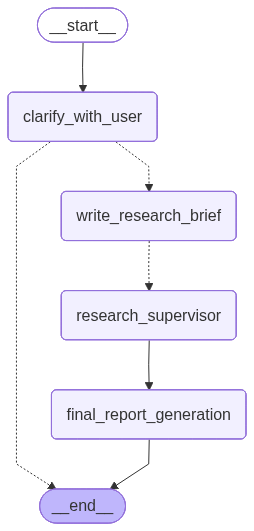

In [7]:


# Note: deep_researcher is already compiled from the library
# For this demo, we'll use it directly without additional checkpointing
graph = deep_researcher

graph

## Supervisor Subgraph

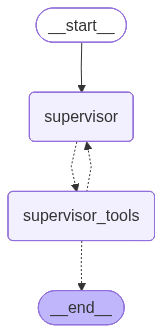

In [25]:
from open_deep_library.deep_researcher import supervisor_subgraph
supervisor_subgraph

## Researcher Subgraph (called by supervisor tools node)

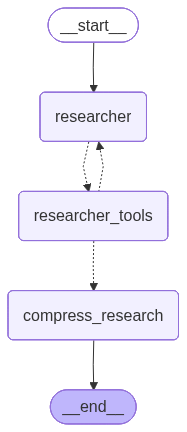

In [24]:
from open_deep_library.deep_researcher import researcher_subgraph
researcher_subgraph

### Configuration for Anthropic

We'll configure the system to use:
- **Claude Sonnet 4** for all research, supervision, and report generation
- **Tavily** for web search (you can also use Anthropic's native search)
- **Moderate parallelism** (3 concurrent researchers)
- **Clarification enabled** (will ask if research scope is unclear)

In [20]:
# Configure for Anthropic with moderate settings
config = {
    "configurable": {
        # Model configuration - using Claude Sonnet 4 for everything
        "research_model": "anthropic:claude-sonnet-4-20250514",
        "research_model_max_tokens": 10000,
        
        "compression_model": "anthropic:claude-sonnet-4-20250514",
        "compression_model_max_tokens": 8192,
        
        "final_report_model": "anthropic:claude-sonnet-4-20250514",
        "final_report_model_max_tokens": 10000,
        
        "summarization_model": "anthropic:claude-sonnet-4-20250514",
        "summarization_model_max_tokens": 8192,
        
        # Research behavior
        "allow_clarification": True,
        "max_concurrent_research_units": 1,  # 1 parallel researchers
        "max_researcher_iterations": 2,      # Supervisor can delegate up to 2 times
        "max_react_tool_calls": 3,           # Each researcher can make up to 3 tool calls
        
        # Search configuration
        "search_api": "tavily",  # Using Tavily for web search
        "max_content_length": 50000,
        
        # Thread ID for this conversation
        "thread_id": str(uuid.uuid4())
    }
}

print("✓ Configuration ready")
print(f"  - Research Model: Claude Sonnet 4")
print(f"  - Max Concurrent Researchers: 3")
print(f"  - Max Iterations: 4")
print(f"  - Search API: Tavily")

✓ Configuration ready
  - Research Model: Claude Sonnet 4
  - Max Concurrent Researchers: 3
  - Max Iterations: 4
  - Search API: Tavily


### Execute the Research

Now let's run the research! We'll ask the system to analyze the PDF and provide insights about how people use AI.

The workflow will:
1. **Clarify** - Check if the request is clear (may skip if obvious)
2. **Research Brief** - Transform our request into a structured brief
3. **Supervisor** - Plan research strategy and delegate to researchers
4. **Parallel Research** - Multiple researchers gather information simultaneously
5. **Compression** - Each researcher synthesizes their findings
6. **Final Report** - All findings combined into comprehensive report

In [21]:
# Create our research request with PDF context
research_request = f"""
I have a PDF document about how people use AI. Please analyze this document and provide insights about:

1. What are the main findings about how people are using AI?
2. What are the most common use cases?
3. What trends or patterns emerge from the data?

Here's the PDF content:

{pdf_content[:10000]}  # First 10k chars to stay within limits

...[content truncated for context window]
"""

# Execute the graph
async def run_research():
    """Run the research workflow and display results."""
    print("Starting research workflow...\n")
    
    async for event in graph.astream(
        {"messages": [{"role": "user", "content": research_request}]},
        config,
        stream_mode="updates"
    ):
        # Display each step
        for node_name, node_output in event.items():
            print(f"\n{'='*60}")
            print(f"Node: {node_name}")
            print(f"{'='*60}")
            
            if node_name == "clarify_with_user":
                if "messages" in node_output:
                    last_msg = node_output["messages"][-1]
                    print(f"\n{last_msg.content}")
            
            elif node_name == "write_research_brief":
                if "research_brief" in node_output:
                    print(f"\nResearch Brief Generated:")
                    print(f"{node_output['research_brief'][:500]}...")
            
            elif node_name == "supervisor":
                print(f"\nSupervisor planning research strategy...")
                if "supervisor_messages" in node_output:
                    last_msg = node_output["supervisor_messages"][-1]
                    if hasattr(last_msg, 'tool_calls') and last_msg.tool_calls:
                        print(f"Tool calls: {len(last_msg.tool_calls)}")
                        for tc in last_msg.tool_calls:
                            print(f"  - {tc['name']}")
            
            elif node_name == "supervisor_tools":
                print(f"\nExecuting supervisor's tool calls...")
                if "notes" in node_output:
                    print(f"Research notes collected: {len(node_output['notes'])}")
            
            elif node_name == "final_report_generation":
                if "final_report" in node_output:
                    print(f"\n" + "="*60)
                    print("FINAL REPORT GENERATED")
                    print("="*60 + "\n")
                    display(Markdown(node_output["final_report"]))
    
    print("\n" + "="*60)
    print("Research workflow completed!")
    print("="*60)

# Run the research
await run_research()

Starting research workflow...


Node: clarify_with_user

I have sufficient information to proceed with your analysis request. You've provided a comprehensive PDF document from the NBER Working Paper titled "How People Use ChatGPT" and requested insights about:

1. Main findings about how people are using AI
2. Most common use cases
3. Trends or patterns emerging from the data

The document contains detailed research data on ChatGPT usage patterns from May 2024 to June 2025, including demographic information, work vs. non-work usage statistics, and classification of conversation topics. I will now begin analyzing this document to provide you with comprehensive insights on AI usage patterns, common use cases, and emerging trends.

Node: write_research_brief

Research Brief Generated:
I have a PDF document titled "How People Use ChatGPT" (NBER Working Paper No. 34255, September 2025) that analyzes ChatGPT usage patterns from May 2024 to June 2025. I need you to analyze this document and p


Node: research_supervisor

Node: final_report_generation

FINAL REPORT GENERATED



# How People Use ChatGPT: Comprehensive Analysis of AI Usage Patterns

The NBER Working Paper No. 34255 "How People Use ChatGPT" represents one of the most comprehensive analyses of large language model (LLM) chatbot usage ever conducted. Published in September 2025 by researchers from Duke University, Harvard University, and OpenAI, this study provides unprecedented insights into how the world's population is actually using AI technology in their daily lives.

## Executive Summary and Key Growth Statistics

ChatGPT's adoption has been nothing short of extraordinary. By July 2025, the platform reached over 700 million weekly active users, representing approximately 10% of the world's adult population [1][2]. This represents unprecedented speed of global technology diffusion, with no historical precedent for such rapid adoption of a new technology.

The scale of usage is staggering: by June 2025, ChatGPT users were sending more than 2.6 billion messages per day, or over 30,000 messages per second [1][2]. This represents a 5.8x increase in message volume over just one year. By July 2025, the platform was processing approximately 18 billion messages per week [8]. The growth trajectory shows ChatGPT reaching 1 million users by December 5, 2022, hitting 100 million weekly active users in early November 2023, and doubling its user base every 7-8 months since then [1].

## Demographic Patterns and User Characteristics

### Age Distribution and Generational Usage

One of the most striking findings is the youth-dominated user base. Nearly half of all messages come from users under 26 years old [1][2][4]. The 18-25 age group dominates usage patterns, suggesting that younger generations are leading the adoption of AI technology for both personal and professional purposes.

### Gender Balance Evolution

The study reveals a dramatic shift in gender representation over time. Initially, over 80% of weekly active users had typically male first names, reflecting the early adopter pattern common in technology products. However, by July 2025, this gender gap had not only closed but slightly reversed, with 52% of users having typically feminine names [1][2]. This represents a remarkable transformation from 37% female usage to over 52% in just 18 months [4], indicating that AI tools like ChatGPT are achieving broad demographic appeal beyond traditional technology early adopters.

### Geographic and Economic Patterns

The research reveals that adoption patterns are particularly strong in developing economies. Usage growth has been fastest in middle-income countries, with nations in middle GDP per capita deciles showing 5-6x growth compared to 3x growth in the richest countries [1]. The fastest growth occurred in low- and middle-income countries, with adoption rates in the lowest-income countries now 4x faster than in the wealthiest nations [4]. This pattern suggests that AI technology is democratizing access to advanced capabilities across economic boundaries.

### Education and Professional Background

Higher education levels correlate strongly with work-related usage patterns [1][2]. Work usage is more prevalent among educated users in highly-paid professional occupations [3][4][5], indicating that knowledge workers are particularly finding value in AI assistance for their professional tasks.

## Work vs. Non-Work Usage Trends

### The Shift Toward Personal Use

One of the most significant findings is the dramatic shift from work-focused to personal usage. The study documents steady growth in work-related messages but even faster growth in non-work-related messages. Non-work usage has grown from 53% to more than 70% of all conversations between mid-2024 and mid-2025 [1][3][4][5]. This means that work-related prompts now account for just 25-30% of total usage, with the remaining 70% being life-related applications [4].

### Professional Applications

Despite representing a smaller share of total usage, work applications show distinct patterns. Writing dominates work-related tasks, highlighting chatbots' unique ability to generate digital outputs compared to traditional search engines [3][4][5]. About 40% of work-related messages involve writing tasks—emails, reports, edits, translations [3][6]. Work contexts also show higher "Doing" activity at 56% compared to general usage patterns [2].

### Personal and Life Applications

The research reveals that ChatGPT is functioning less as a work assistant and more as what the authors term "the world's most-used life assistant" [4]. This represents a fundamental shift in how AI technology is being integrated into daily life, extending far beyond professional productivity tools.

## Three Primary Use Case Categories

The study identifies three dominant categories that collectively account for nearly 80% of all ChatGPT conversations [1][2][3][4][5][6]:

### Practical Guidance (29%)

This category represents the largest single use case, encompassing tutoring and teaching, how-to advice across various topics, and creative ideation [6]. Users are leveraging ChatGPT as a comprehensive advisor for life decisions, learning support, and problem-solving guidance. This category reflects the platform's role as a decision-support tool rather than simply a content generator.

### Seeking Information (24%)

This usage pattern closely mirrors traditional web search functionality but with enhanced contextual understanding. Users employ ChatGPT for facts, research, and lookups [8], but with the advantage of receiving synthesized answers that make sense within their specific context rather than having to "click through ten links" [8]. This represents a fundamental shift in how people access and process information.

### Writing (24%)

The writing category encompasses not just content creation but also editing, critiques, translations, and summaries [6]. Notably, about two-thirds of writing tasks involve editing, critiques, translations, or summaries of user-provided text rather than creating entirely new content [8]. This suggests that users are primarily seeking enhancement and refinement of their existing work rather than complete automation of writing tasks.

## Additional Use Case Categories

### Technical Applications

Contrary to popular perception that ChatGPT is primarily used for coding, computer programming accounts for only 4.2% of consumer conversations [6][8]. This relatively small percentage challenges assumptions about AI's primary value proposition and suggests that non-technical applications dominate real-world usage.

### Creative and Multimedia Applications

Multimedia applications account for 7% of usage, with users rushing to use image generation capabilities for presentations, branding, and creative projects once the functionality became seamlessly integrated [8].

### Personal Expression and Relationships

Self-expression represents 2% of total usage, which may sound minimal but scales to 14 million people weekly sending 52 million messages daily [8]. Relationship and personal reflection conversations account for approximately 1.9% of usage [8], indicating that users are finding value in AI for personal development and emotional support.

## User Interaction Patterns and Behavior

### Types of User Intent

The research categorizes user interactions into three fundamental types:
- **Asking (~49%)**: Seeking advice, clarity, or decision support [3]
- **Doing (~40%)**: Task completion and execution
- **Expressing (~11%)**: Personal communication and self-expression

Consumer usage splits into approximately 49% Asking, 40% Doing, and 11% Expressing, with Asking messages growing faster than Doing [8]. Nearly half of all prompts involve seeking advice or decision support, reinforcing the platform's primary role as a thinking partner rather than just a task executor.

### User Satisfaction and Engagement

User satisfaction metrics are notably high, with positive interactions outnumbering negative ones by approximately 4:1 [1][2]. Asking messages are consistently rated higher than Doing messages by both interaction-quality classifiers and direct user feedback [8], suggesting that users find the greatest value in the platform's advisory and decision-support capabilities.

### Behavioral Changes Over Time

All user cohorts experienced relatively flat usage through most of 2024, followed by substantial increases beginning in early 2025, suggesting that ChatGPT became significantly better or more user-friendly during this period [1]. Early adopters from Q1 2023 were sending 40% more messages per day by July 2025 than they did two years earlier [1], indicating increasing reliance and integration into daily workflows and personal routines.

## Methodology and Research Approach

### Privacy-Preserving Analysis Framework

The study employed rigorous privacy protection measures that set new standards for research on sensitive user data. The researchers used a Data Clean Room (DCR) system where no member of the research team ever saw the content of user messages or observed any aspect of users' personal information [1][2]. All analyses were conducted through automated classifiers that provided only aggregated outputs, with all personally identifiable information automatically scrubbed [1].

### Automated Classification Pipeline

The research utilized a sophisticated automated classification system using multiple taxonomies to categorize messages by work relatedness, conversation topic, interaction type, and O*NET task categories [3]. Each taxonomy was defined through prompts passed to LLMs, allowing classification without human exposure to message content. The classification pipeline analyzed not just individual messages but also portions of preceding conversation context [3].

### Sample Size and Data Validation

The study analyzed 1.5 million ChatGPT conversations from a representative sample [6], with data drawn from consumer plans (Free, Plus, and Pro) between May 2024 and June 2025. The research excluded users who opted out of sharing messages for model training, self-reported minors, logged-out users, deleted conversations, and deactivated accounts [1]. The study received Harvard IRB approval and underwent multiple validation cycles [3].

## Economic and Social Implications

### Economic Value Assessment

The researchers estimate that U.S. users would need to be paid roughly $98 to give up generative AI for a month, implying at least $97 billion in annual consumer surplus [6]. This substantial economic value creation doesn't appear in traditional economic measurements, suggesting that AI's impact may be significantly underestimated in conventional economic analysis.

The study concludes that ChatGPT's primary economic value lies in its role as a decision-support tool, helping users make choices, solve problems, and produce better writing through tailored, actionable outputs [1][2]. This value is especially pronounced in knowledge-intensive jobs where decision-making and communication are central to productivity [1][3][4][5].

### Societal Impact and Future Implications

The research indicates a fundamental shift in how individuals interact with information and make decisions. Rather than simple task automation, ChatGPT functions as structured thinking support at conversational speed [8]. The authors suggest that instead of asking "What will AI replace?" the more relevant questions are: "Who gets smarter faster? Who adapts better? Who asks better questions?" [4].

The study reveals that AI is transitioning from knocking at the office door to "sitting in the living room" [4], indicating a broad integration into personal life that may have more profound implications than workplace adoption alone. This suggests we're entering an era of AI-augmented individuals rather than just AI-powered businesses [4].

### Technology Adoption Insights

Contrary to typical technology adoption patterns that often exacerbate inequality, demographic gaps in ChatGPT usage are rapidly closing [1]. The platform appears to be achieving broad democratization across gender, geographic, and economic boundaries, though educational and professional differences remain significant factors in work-related usage patterns.

## Trends and Future Patterns

### Changing Usage Composition

The shift from work-focused to life-focused applications represents one of the most significant trends identified in the study. This change is primarily driven by evolving usage patterns within existing user cohorts rather than changes in the composition of new users [1][3][4][5]. This suggests that as users become more familiar with AI capabilities, they find increasing value in personal and life applications.

### Cognitive Assistance Evolution

The research suggests that ChatGPT is evolving into a "universal cognitive assistant" that helps people decide, learn, and communicate [8]. Rather than replacing human effort, the platform appears to be augmenting human decision-making capabilities and providing structured thinking support.

### Global Adoption Patterns

The particularly strong adoption in developing economies suggests that AI technology may be leapfrogging traditional technological infrastructure limitations, similar to how mobile phones enabled communication advances in regions without extensive landline networks. This pattern could have significant implications for global economic development and technological equality.

## Conclusion

The NBER study reveals that ChatGPT usage has evolved far beyond initial expectations, transforming from a primarily work-focused tool to a comprehensive life assistant used by 10% of the world's adult population. The dominant usage patterns—Practical Guidance, Seeking Information, and Writing—suggest that users primarily value AI as a thinking partner and decision-support system rather than a simple task automation tool.

The rapid closing of demographic gaps, the shift toward personal applications, and the high user satisfaction rates indicate that AI technology is achieving broad social adoption with significant economic value. The estimated $97 billion in annual consumer surplus suggests that the societal impact of AI may be substantially larger than traditional economic measures capture.

As AI continues to integrate into daily life, the research suggests we are witnessing the emergence of AI-augmented individuals who can think more clearly, decide more quickly, and communicate more effectively. This transformation may represent one of the most significant technological shifts in human cognitive augmentation, with implications extending far beyond workplace productivity to encompass fundamental changes in how people navigate decisions, learning, and communication in their personal lives.

### Sources

[1] How People Really Use ChatGPT: Findings from NBER Research: https://techmaniacs.com/2025/09/15/how-people-really-use-chatgpt-findings-from-nber-research/
[2] How People Use ChatGPT - by David Deming - Forked Lightning: https://forklightning.substack.com/p/how-people-use-chatgpt
[3] How People Use ChatGPT | NBER: https://www.nber.org/papers/w34255
[4] How people really use ChatGPT: surprising findings from NBER paper: https://www.linkedin.com/posts/philipp-osterwalder_how-do-people-really-use-chatgpt-a-brand-new-activity-7374740089941225472-JmXb
[5] How People Use ChatGPT - SSRN: https://papers.ssrn.com/sol3/papers.cfm?abstract_id=5487080
[6] What Is ChatGPT Used For In 2025, Proven NBER Insights: https://binaryverseai.com/what-is-chatgpt-used-for/
[7] ChatGPT usage study reveals 700M weekly users, mostly non-work: https://www.linkedin.com/posts/khalid-baba-phd-93b275b8_full-paper-nber-working-paper-34255-activity-7373805827704508417-1Y3f
[8] How People Actually Use ChatGPT - Towards AI: https://pub.towardsai.net/how-people-actually-use-chatgpt-2790df683c00


Research workflow completed!


## Understanding the Output

Let's break down what happened:

### Phase 1: Clarification
The system checked if your request was clear. Since you provided a PDF and specific questions, it likely proceeded without clarification.

### Phase 2: Research Brief
Your request was transformed into a detailed research brief that guides the supervisor's delegation strategy.

### Phase 3: Supervisor Delegation
The supervisor analyzed the brief and decided how to break down the research:
- Used `think_tool` to plan strategy
- Called `ConductResearch` multiple times to delegate to parallel researchers
- Each delegation specified a focused research topic

### Phase 4: Parallel Research
Multiple researchers worked simultaneously:
- Each researcher used web search tools to gather information
- Used `think_tool` to reflect after each search
- Decided when they had enough information
- Compressed their findings into clean summaries

### Phase 5: Final Report
All research findings were synthesized into a comprehensive report with:
- Well-structured sections
- Inline citations
- Sources listed at the end
- Balanced coverage of all findings

#### 🏗️ Activity #1: Try Different Configurations

You can experiment with different settings to see how they affect the research.  You may select three or more of the following settings (or invent your own experiments) and describe the results.

### Increase Parallelism
```python
"max_concurrent_research_units": 10  # More researchers working simultaneously
```

### Deeper Research
```python
"max_researcher_iterations": 8   # Supervisor can delegate more times
"max_react_tool_calls": 15      # Each researcher can search more
```

### Use Anthropic Native Search
```python
"search_api": "anthropic"  # Use Claude's built-in web search
```

### Disable Clarification
```python
"allow_clarification": False  # Skip clarification phase
```

## Key Takeaways

### Architecture Benefits
1. **Dynamic Decomposition** - Research structure emerges from the question, not predefined
2. **Parallel Efficiency** - Multiple researchers work simultaneously
3. **ReAct Quality** - Strategic reflection improves search decisions
4. **Scalability** - Handles token limits gracefully through compression
5. **Flexibility** - Easy to add new tools and capabilities

### When to Use This Pattern
- **Complex research questions** that need multi-angle investigation
- **Comparison tasks** where parallel research on different topics is beneficial
- **Open-ended exploration** where structure should emerge dynamically
- **Time-sensitive research** where parallel execution speeds up results

### When to Use Section-Based Instead
- **Highly structured reports** with predefined format requirements
- **Template-based content** where sections are always the same
- **Sequential dependencies** where later sections depend on earlier ones
- **Budget constraints** where token efficiency is critical

## Next Steps

### Extend the System
1. **Add MCP Tools** - Integrate specialized tools for your domain
2. **Custom Prompts** - Modify prompts for specific research types
3. **Different Models** - Try different Claude versions or mix models
4. **Persistence** - Use a real database for checkpointing instead of memory

### Learn More
- [LangGraph Documentation](https://langchain-ai.github.io/langgraph/)
- [Open Deep Research Repo](https://github.com/langchain-ai/open_deep_research)
- [Anthropic Claude Documentation](https://docs.anthropic.com/)
- [Tavily Search API](https://tavily.com/)

### Deploy
- Use LangGraph Cloud for production deployment
- Add proper error handling and logging
- Implement rate limiting and cost controls
- Monitor research quality and costs

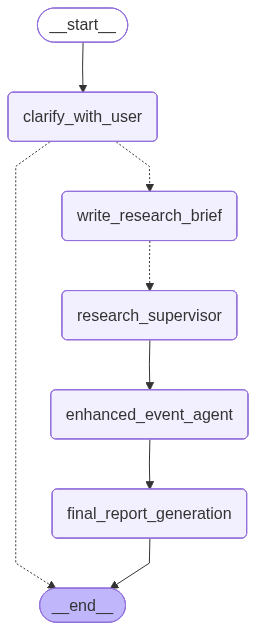

In [36]:
from open_deep_library.deep_researcher import enhanced_researcher
enhanced_researcher

In [37]:
# Enhanced Activity #1 Configuration with Website Scraping
config_2_enhanced = {
    "configurable": {
        # Mixed model configuration - OpenAI and Claude Sonnet 4
        "research_model": "openai:gpt-4o-mini",                    
        "research_model_max_tokens": 10000,
        
        "compression_model": "openai:gpt-4o-mini",  # Claude for compression
        "compression_model_max_tokens": 8192,
        
        "final_report_model": "openai:gpt-4o-mini",  # Claude for final report
        "final_report_model_max_tokens": 10000,
        
        "summarization_model": "openai:gpt-4o-mini",          # OpenAI for summarization
        "summarization_model_max_tokens": 8192,
        
        # Research behavior - Activity #1 experiments
        "allow_clarification": False,                         # Skip clarification phase
        "max_concurrent_research_units": 10,                  # More researchers working simultaneously
        "max_researcher_iterations": 8,                       # Supervisor can delegate more times
        "max_react_tool_calls": 15,                           # Each researcher can search more

        # Search configuration
        "search_api": "anthropic",                            # Use Claude's native web search
        "max_content_length": 50000,
        
        # Enhanced Event Search Configuration
        "enable_website_scraping": True,                      # Enable specific website scraping
        "scrape_resident_advisor": True,                      # Scrape ra.co for electronic music
        
        # Event search settings
        "default_event_location": "Athens, Greece",           # Default location for event searches
        "default_event_type": "electronic music",             # Default event type
        "max_events_per_source": 5,                           # Limit events per source
        "event_search_timeout": 30,                           # Timeout for event searches
        
        # Website scraping settings
        "scraping_user_agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36",
        "scraping_timeout": 10,                               # Timeout for website requests
        "max_scraping_retries": 3,                            # Max retries for failed scrapes
        
    
    }
}



In [38]:
async def run_enhanced_research_with_scraping():
    """Run the enhanced research workflow with website scraping capabilities"""
    
    # Create a research request that will benefit from event website scraping
    research_request = """
    Find techno events in Athens, Greece for 2025.
    Please provide insights about:
    
    1. What are the most popular electronic music venues in Athens?
    2. What types of electronic music events are happening in 2025?
    3. Who are the key DJs and artists performing in Athens?
    4. What are the best techno and house music events to attend?
    5. Are there any major electronic music festivals planned?
    
    Please include specific event information and links to event pages for more details.
    """
    
    print("🚀 Starting Enhanced Research with Website Scraping...")
    print("=" * 70)
    print("🎪 Event Sources: Eventbrite, Athens Voice, Songkick, Ticketmaster")
    print("=" * 70)
    
    async for event in enhanced_researcher.astream(
        {"messages": [{"role": "user", "content": research_request}]},
        config_2_enhanced,  # Use enhanced configuration
        stream_mode="updates"
    ):
        for node_name, node_output in event.items():
            print(f"\n📋 Node: {node_name}")
            print("-" * 50)
            
            if node_name == "enhanced_event_agent":
                if "notes" in node_output:
                    print("🎪 Enhanced Event Agent Results:")
                    for note in node_output["notes"]:
                        print(f"   {note}")
            
            elif node_name == "final_report_generation":
                if "final_report" in node_output:
                    print("📄 Final Report Generated!")
                    print("=" * 70)
                    display(Markdown(node_output["final_report"]))
    
    print("\n✅ Enhanced research workflow with website scraping completed!")
    print("🎵 Check the results above for events from Eventbrite and other sources!")

await run_enhanced_research_with_scraping()


🚀 Starting Enhanced Research with Website Scraping...
🎪 Event Sources: Eventbrite, Athens Voice, Songkick, Ticketmaster

📋 Node: clarify_with_user
--------------------------------------------------

📋 Node: write_research_brief
--------------------------------------------------

📋 Node: research_supervisor
--------------------------------------------------

📋 Node: enhanced_event_agent
--------------------------------------------------
🎪 Enhanced Event Agent Results:
   Event Search Results for techno events in Athens:

🎪 Eventbrite Events for techno in Athens:

1. Athens Pub Crawl with Unlimited Drinks & Nightclub Access
   📅 Unknown
   🏢 Unknown
   🔗 https://www.eventbrite.co.uk/e/athens-pub-crawl-with-unlimited-drinks-nightclub-access-tickets-1742167964279?aff=ebdssbdestsearch

2. Athens Pub Crawl with Unlimited Drinks & Nightclub Access
   📅 Unknown
   🏢 Unknown
   🔗 https://www.eventbrite.co.uk/e/athens-pub-crawl-with-unlimited-drinks-nightclub-access-tickets-1742167964279?aff=ebd

# Techno and House Music Events in Athens, Greece - 2025

As Athens continues to establish its reputation as a vibrant hub for electronic music, the year 2025 appears promising for techno and house music enthusiasts. Below is a comprehensive overview of the expected events, notable venues, key artists, and major festivals scheduled to take place in the city.

## Popular Electronic Music Venues in Athens

1. **Boiler Athens**
   - Known for its intimate atmosphere and top-tier line-ups, Boiler is a staple in Athens' nightlife.
   - Regularly hosts both local and international DJs, focusing mainly on techno and house genres.

2. **Release Athens Festival Grounds**
   - An expansive venue known for large electronic music festivals and events, attracting major names in the electronic music scene.
   - Offers outdoor spaces perfect for festival-style events.

3. **Six d.o.g.s**
   - A multidisciplinary space that features a bar, restaurant, and performance areas.
   - Hosts various electronic music events, featuring a mix of genres including techno and house.

4. **Athens Family**
   - A unique venue that promotes underground music culture and local artists.
   - Often features various techno events that cater to a dedicated crowd.

5. **Rooftop venues like A for Athens**
   - Offer a scenic view of the Acropolis while hosting electronic music events during the summer months.

## Types of Electronic Music Events Scheduled for 2025

In 2025, Athens will host a wide range of electronic music events, including:

- **Weekly Club Nights**
  - Many local clubs are expected to feature regular techno and house nights, showcasing both emerging and established artists.

- **Special Guest Events**
  - Clubs like Boiler and Six d.o.g.s will likely attract international DJs for one-off performances, drawing crowds eager for high-quality electronic music experiences.

- **Themed Parties**
  - Expect a variety of thematic events that incorporate elements of visuals and sound, fostering a comprehensive party experience.

## Key DJs and Artists Performing in Athens

While specific line-ups are still being confirmed, typical performers for the 2025 lineup may include:

- **Dimitri Vegas & Like Mike**
  - Known for their high-energy performances, they have a significant following and are likely to be featured at major festivals.

- **Amelie Lens**
  - A prominent techno DJ, she's gained acclaim for her unique sound and is expected to perform at high-profile events.

- **Solomun**
  - Renowned for his long DJ sets and deep house music style, Solomun is a favorite among electronic music fans.

- **Local Talents**
  - Athens boasts a range of local talent in the electronic music scene that will be performing regularly throughout 2025.

## Notable Techno and House Music Events Worth Attending

### Notable Events

1. **Release Athens**
   - A major festival typically held in the summer, featuring prominent electronic artists and DJs across multiple stages. While official dates for 2025 are pending, the annual festival is expected.
   - More information available [here](https://releaseathens.gr).

2. **Boiler Room Events**
   - Boiler Room events offer a unique viewing experience for live DJ performances and are a hallmark for electronic music lovers. Specific dates for their 2025 events will be announced in early 2025. 

3. **Local Club Events**
   - Various clubs will frequently host weekend events showcasing a rotating lineup of local and international DJs, often including themed nights.

## Major Electronic Music Festivals Planned

1. **Reworks**
   - Usually held in late summer, Reworks is one of the largest electronic music festivals in Greece, featuring a blend of local and international artists. Confirmation of dates for 2025 will typically occur early in the year.
   - More insights can be found [here](https://reworks.gr).

2. **Release Athens**
   - Again, plan for this festival held at the Release Athens grounds, where the electronic music community comes together for an immersive weekend experience.

## Conclusion

With a vibrant electronic scene and numerous events scheduled throughout 2025, Athens promises to be an exciting destination for techno and house music lovers. Whether attending intimate club nights or large-scale festivals, attendees can expect a diverse array of music and cultural experiences.

### Sources
[1] Release Athens - Official Website: https://releaseathens.gr  
[2] Reworks - Official Website: https://reworks.gr  


✅ Enhanced research workflow with website scraping completed!
🎵 Check the results above for events from Eventbrite and other sources!
